# Visium HD tutorial

We can run Sopa on Visium HD, as the 2 micron bins are subcellular. You can follow the ["normal" API tutorial](../api_usage), or continue below to get exemples more specific to Visium HD data.

For this tutorial, we use the [mouse small intestine public dataset](https://www.10xgenomics.com/datasets/visium-hd-cytassist-gene-expression-libraries-of-mouse-intestine) from 10X Genomics.

In [1]:
import sopa
import spatialdata

/Users/quentinblampey/mambaforge/envs/sopa/lib/python3.10/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/Users/quentinblampey/mambaforge/envs/sopa/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


## Reading the data

In [2]:
sdata_full = sopa.io.visium_hd("data/visium_hd/Visium_HD_Mouse_Small_Intestine")
sdata_full

/Users/quentinblampey/mambaforge/envs/sopa/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


SpatialData object
├── Images
│     ├── 'Visium_HD_Mouse_Small_Intestine_full_image': DataTree[cyx] (3, 21943, 23618), (3, 10971, 11809), (3, 5485, 5904), (3, 2742, 2952), (3, 1371, 1476)
│     ├── 'Visium_HD_Mouse_Small_Intestine_hires_image': DataArray[cyx] (3, 5575, 6000)
│     └── 'Visium_HD_Mouse_Small_Intestine_lowres_image': DataArray[cyx] (3, 558, 600)
├── Shapes
│     └── 'Visium_HD_Mouse_Small_Intestine_square_002um': GeoDataFrame shape: (5479660, 1) (2D shapes)
└── Tables
      └── 'square_002um': AnnData (5479660, 19059)
with coordinate systems:
    ▸ 'downscaled_hires', with elements:
        Visium_HD_Mouse_Small_Intestine_hires_image (Images), Visium_HD_Mouse_Small_Intestine_square_002um (Shapes)
    ▸ 'downscaled_lowres', with elements:
        Visium_HD_Mouse_Small_Intestine_lowres_image (Images), Visium_HD_Mouse_Small_Intestine_square_002um (Shapes)
    ▸ 'global', with elements:
        Visium_HD_Mouse_Small_Intestine_full_image (Images), Visium_HD_Mouse_Small_Intest

For simplicity, we crop the dataset (so that the tutorial runs faster).

In [3]:
sdata = sdata_full.query.bounding_box(
    axes=["y", "x"], min_coordinate=[10_000, 10_000], max_coordinate=[15_000, 15_000], target_coordinate_system="global"
)

/Users/quentinblampey/mambaforge/envs/sopa/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Then, we save it on-disk:

In [ ]:
sdata.write("sub_visium_hd.zarr") # save it

sdata = spatialdata.read_zarr("sub_visium_hd.zarr") # open-it back

/Users/quentinblampey/mambaforge/envs/sopa/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


## Usual pipeline

Now, we run Sopa as usual. Although, since we don't have transcripts, we can't run Baysor. Therefore, we will run Cellpose on the H&E image.

### Tissue segmentation

But, first, since the tissue is very sparse, we can segment it (i.e., create the contour of the tissue).

In [ ]:
sopa.segmentation.tissue(sdata, expand_radius_ratio=0.05)

We can see the contour of the tissue in red:

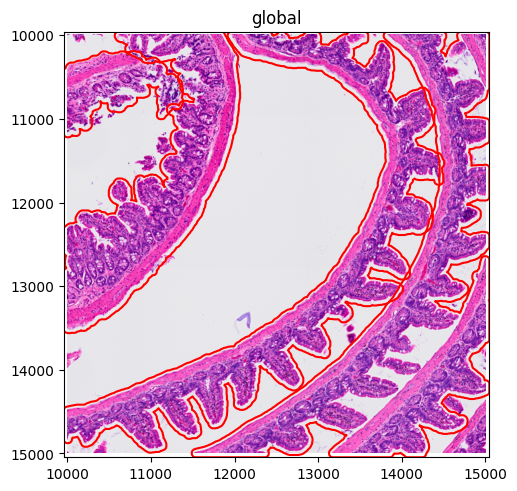

In [4]:
import spatialdata_plot

sdata \
    .pl.render_images("Visium_HD_Mouse_Small_Intestine_full_image") \
    .pl.render_shapes("region_of_interest", outline_alpha=1, outline_color="r", fill_alpha=0) \
    .pl.show("global")

### Cell segmentation

Then, we create the patches for the cell segmentation.

In [11]:
sopa.make_image_patches(sdata)

/Users/quentinblampey/dev/_external/spatialdata/src/spatialdata/_core/_elements.py:96: UserWarning: Key `image_patches` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
[INFO] (sopa.patches._patches) 9 patches were added to sdata['image_patches']


For faster segmentation, we recommend using the `"dask"` parallelization backend:

In [12]:
sopa.settings.parallelization_backend = "dask" # optional
sopa.settings.dask_client_kwargs = {"n_workers": 4} # optional

Now we can run cellpose on the `"r"` channel (from the `rgb` image):

In [ ]:
sopa.segmentation.cellpose(sdata, channels=["r"], diameter=15, min_area=50)

## Aggregation

Now, we need to aggregate the bins into the cells. For each cell, Sopa will sum the transcript counts of all 2-microns-bins touching or included within the cell.

> There is an argument `bins_key`, but by default Sopa will understand that it's Visium HD data and that it should use the 2-microns bins. Also, on the example below, we only aggregate the bins, not the H&E channels.

In [19]:
sopa.aggregate(sdata, aggregate_channels=False)

/Users/quentinblampey/mambaforge/envs/sopa/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/quentinblampey/mambaforge/envs/sopa/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/quentinblampey/dev/_external/spatialdata/src/spatialdata/_core/_elements.py:96: UserWarning: Key `cellpose_boundaries` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


## Single-cell table

Now, we have an AnnData object with the gene expression **per cell**.

In [5]:
adata = sdata["table"]
adata

AnnData object with n_obs × n_vars = 26165 × 19059
    obs: 'region', 'slide', 'cell_id', 'area'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'sopa_attrs', 'spatialdata_attrs'
    obsm: 'spatial'

For instance, we can now use Scanpy to plot gene expression.

In [6]:
import scanpy as sc

In [7]:
# basic preprocessing
sc.pp.filter_genes(adata, min_cells=100)
sc.pp.filter_cells(adata, min_counts=100)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

We can then use `sc.pl.spatial` to show the gene expression per cells. Note that, here, we show **cells**, not bins.

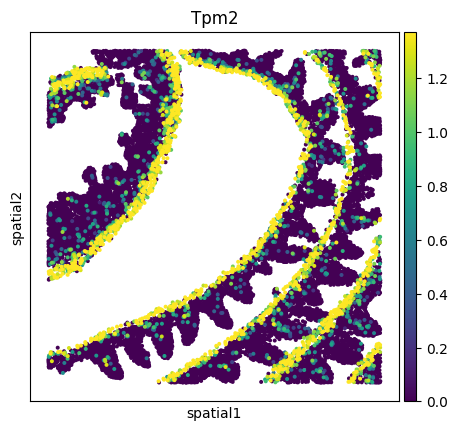

In [8]:
sc.pl.spatial(adata, color="Tpm2", spot_size=60, vmax="p95")

## Bins visualization

The 2-micron bins are arranged in a grid, so they can be visualized as an image of `G` channels, where `G` is the number of genes.

Creating the image would be massive, so we need to create it lazily. This can be done with `spatialdata.rasterize_bins`.

In [16]:
sdata["square_002um"].X = sdata["square_002um"].X.tocsc() # optimisation with the csc format

lazy_bins_image = spatialdata.rasterize_bins(
    sdata,
    bins="Visium_HD_Mouse_Small_Intestine_square_002um", # key of the bins shapes
    table_name="square_002um", # key of the table with the bins gene expression
    row_key="array_row",
    col_key="array_col",
)

Note that `lazy_bins_image` is an image of size `(19059, 690, 690)`, that is `G=19059` genes, and `690x690` bins. This would correspond to a 33.80GB image in memory, if it wasn't lazy.

In [17]:
lazy_bins_image

<xarray.DataArray 'image' (c: 19059, y: 690, x: 690)> Size: 36GB
dask.array<channel_rasterization, shape=(19059, 690, 690), dtype=uint32, chunksize=(1, 690, 690), chunktype=numpy.ndarray>
Coordinates:
  * c        (c) object 152kB 'Xkr4' 'Rp1' 'Sox17' ... 'mt-Cytb' 'Vamp7'
  * y        (y) float64 6kB 0.5 1.5 2.5 3.5 4.5 ... 686.5 687.5 688.5 689.5
  * x        (x) float64 6kB 0.5 1.5 2.5 3.5 4.5 ... 686.5 687.5 688.5 689.5
Attributes:
    transform:  {'global': Sequence \n    Sequence \n        Affine (x, y -> ...

We can save this image in the `sdata` object.

In [21]:
sdata["gene_expression_2_um"] = lazy_bins_image

Then, we can visualize this image with Napari. When showing a gene, it will compute the corresponding layer of the lazy image, and it will be displayed in milliseconds, i.e. looking instantaneous.

In [ ]:
from napari_spatialdata import Interactive

Interactive(sdata)

You'll be able to display cells and the bins expression. It should look like that:

<p align="center">
  <img src="../../assets/napari_visium_hd.png" alt="napari_visium_hd" width="600px"/>
</p>